In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from quantbullet.preprocessing.transformers import FlatRampTransformer
from quantbullet.dfutils import get_bins_and_labels

## Regression Example

In [2]:
np.random.seed(42)
n_samples = 1_000_000
x1 = np.random.uniform(0, 4, n_samples)
x2 = np.random.uniform(4, 8, n_samples)
y = ( x1 - 2 ) ** 2 + np.cos( 3 * x2 ) + np.random.normal(0, 1, n_samples) + 10

df = pd.DataFrame({'x1': x1, 'x2': x2, 'y': y})

In [3]:
x1_trans = FlatRampTransformer(
    knots = [0.5, 1, 1.5, 2, 2.5, 3, 3.5],
    include_bias=True
)

x2_trans = FlatRampTransformer(
    knots = [4.5, 5, 5.5, 6, 6.5, 7, 7.5],
    include_bias=True
)

train_df = np.concatenate([
    x1_trans.fit_transform(df['x1']),
    x2_trans.fit_transform(df['x2']),
], axis=1)

train_df = pd.DataFrame(train_df, columns = x1_trans.get_feature_names_out().tolist() 
                        + x2_trans.get_feature_names_out().tolist())

In [4]:
x1_bins, x1_labels = get_bins_and_labels(cutoffs=np.arange(0.2, 4, 0.2))
x2_bins, x2_labels = get_bins_and_labels(cutoffs=np.arange(4.2, 8, 0.2))
df['x1_bins'] = pd.cut( df['x1'], bins=x1_bins, labels=x1_labels )
df['x2_bins'] = pd.cut( df['x2'], bins=x2_bins, labels=x2_labels )

In [5]:
feature_groups = {'x1': x1_trans.get_feature_names_out().tolist(), 
                  'x2': x2_trans.get_feature_names_out().tolist(),}

In [6]:
from quantbullet.optimizer import LinearProductModelOLS

lpm_ols = LinearProductModelOLS()

In [7]:
lpm_ols.fit( train_df, df['y'], feature_groups=feature_groups, n_iterations=10, early_stopping_rounds=5 )

Iteration 1/10, MSE: 1.0128
Iteration 2/10, MSE: 1.0128
Iteration 3/10, MSE: 1.0128
Iteration 4/10, MSE: 1.0128
Iteration 5/10, MSE: 1.0128
Iteration 6/10, MSE: 1.0128
Early stopping at iteration 6 with MSE: 1.0128


In [8]:
df['model_predict'] = lpm_ols.predict(train_df)

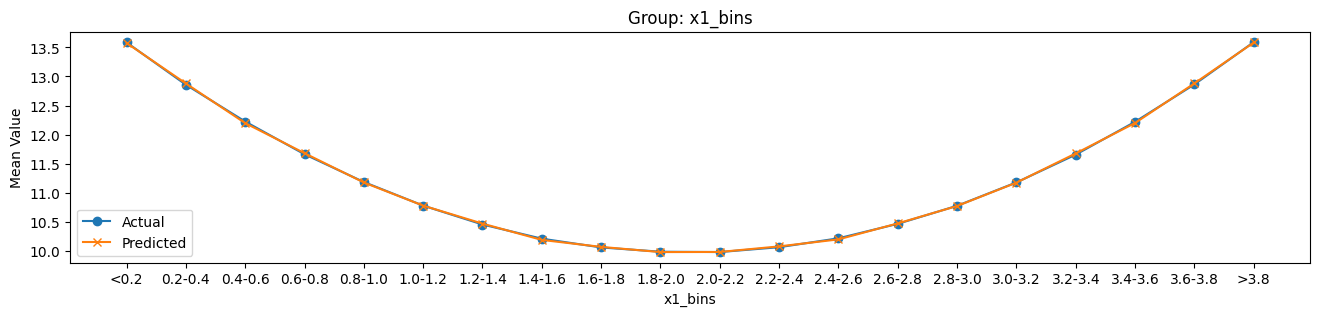

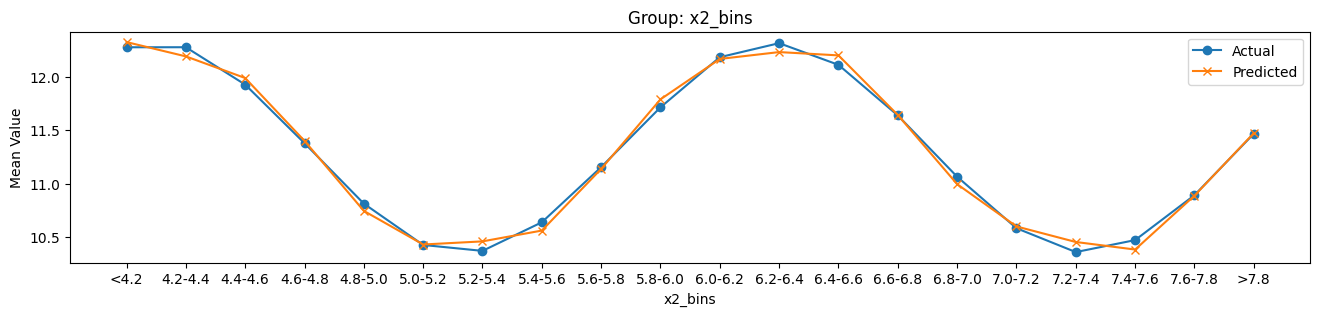

In [9]:
for group in ['x1_bins', 'x2_bins']:
    plt.figure(figsize=(16, 3))
    summary = df.groupby(group, observed=True).agg({'y': 'mean', 'model_predict': 'mean'})
    plt.plot(summary.index, summary['y'], label='Actual', marker='o')
    plt.plot(summary.index, summary['model_predict'], label='Predicted', marker='x')
    plt.title(f'Group: {group}')
    plt.xlabel(group)
    plt.ylabel('Mean Value')
    plt.legend()

## Classification Example: Using Cross-Entropy Loss

In [26]:
probs = 1 / (1 + np.exp(-(df['y'] - 15)))
df['binary_y'] = np.random.binomial(1, probs)
df['binary_y'].mean()

np.float64(0.069841)

In [27]:
from quantbullet.optimizer import LinearProductClassifierScipy

lpc_scipy = LinearProductClassifierScipy(ftol=1e-6, gtol=1e-6, eps=1e-3)

In [28]:
lpc_scipy.fit( train_df, df['binary_y'], feature_groups=feature_groups, init_params=np.ones(train_df.shape[1]) * 0.02, verbose=True )

Iter 1: 285870.1784015961
Iter 2: 251183.15985221142
Iter 3: 251104.29794438736
Iter 4: 250943.54103354207
Iter 5: 250458.33171351682
Iter 6: 250038.33837420607
Iter 7: 249418.85961215175
Iter 8: 247372.66905717266
Iter 9: 241327.16666740004
Iter 10: 232322.62013852372
Iter 11: 232233.02222729853
Iter 12: 231906.32607472158
Iter 13: 230776.58234780087
Iter 14: 228379.5226022893
Iter 15: 227122.47796478387
Iter 16: 226667.11304614792
Iter 17: 226157.85751390006
Iter 18: 224617.0900829893
Iter 19: 223859.61180954074
Iter 20: 223036.39007716562
Iter 21: 222840.68425101822
Iter 22: 222808.47872879796
Iter 23: 222742.40700080985
Iter 24: 222679.77675466464
Iter 25: 222632.48035031106
Iter 26: 222506.26516812007
Iter 27: 222254.47037753122
Iter 28: 221784.05156337694
Iter 29: 221206.54651954866
Iter 30: 221009.42354894502
Iter 31: 220986.9625191024
Iter 32: 220892.99929511672
Iter 33: 220878.15361291924
Iter 34: 220873.32342113764
Iter 35: 220863.7115864269
Iter 36: 220861.6518898672
Iter 37

In [29]:
lpc_scipy.coef_

array([ 2.23630460e+00,  2.23379025e+00,  5.56342621e-01,  1.94067557e-01,
       -1.90216166e-03, -9.01178567e-02,  4.22753603e-02, -1.23837200e+00,
       -1.35760386e-01, -8.99039048e-02,  6.77387963e-02,  4.32305743e-01,
       -3.90570103e-03, -4.51177963e-01, -5.00732892e-02,  4.56199603e-01,
        7.53462959e-02, -4.19872265e-01])

In [30]:
df['clf_scipy_pred_prob'] = lpc_scipy.predict_proba(train_df)

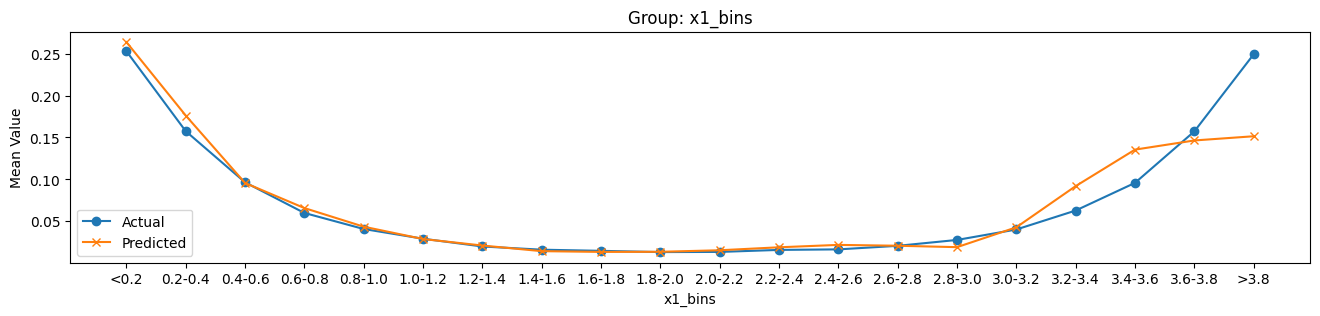

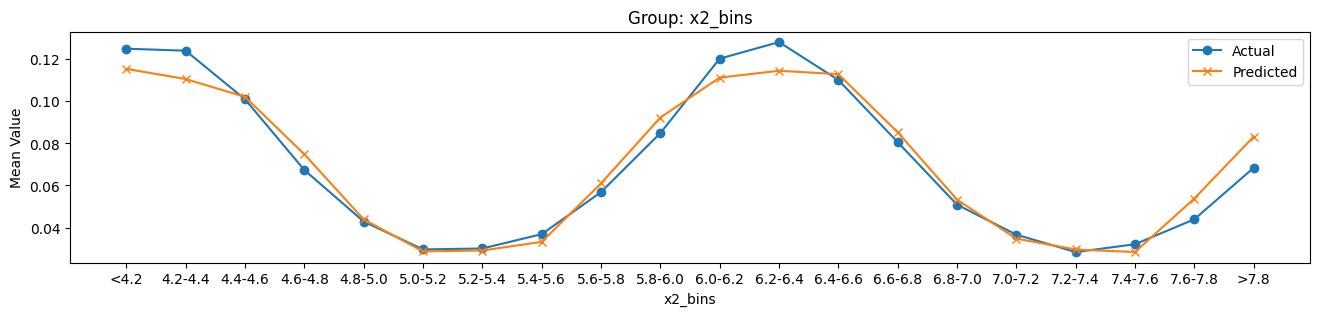

In [31]:
for group in ['x1_bins', 'x2_bins']:
    plt.figure(figsize=(16, 3))
    summary = df.groupby(group, observed=True).agg({'binary_y': 'mean', 'clf_scipy_pred_prob': 'mean'})
    plt.plot(summary.index, summary['binary_y'], label='Actual', marker='o')
    plt.plot(summary.index, summary['clf_scipy_pred_prob'], label='Predicted', marker='x')
    plt.title(f'Group: {group}')
    plt.xlabel(group)
    plt.ylabel('Mean Value')
    plt.legend()

## Classification Example: Minimizing MSE, use OLS for Classification

In [32]:
probs = 1 / (1 + np.exp(-(df['y'] - 15)))
df['binary_y'] = np.random.binomial(1, probs)

In [33]:
from quantbullet.optimizer import LinearProductModelScipy, LinearProductModelOLS

lprm_ols = LinearProductModelOLS()

In [34]:
lprm_ols.fit( train_df, df['binary_y'], feature_groups=feature_groups, n_iterations=10 )

Iteration 1/10, MSE: 0.0574
Iteration 2/10, MSE: 0.0578
Iteration 3/10, MSE: 0.0578
Iteration 4/10, MSE: 0.0578
Iteration 5/10, MSE: 0.0578
Iteration 6/10, MSE: 0.0578
Iteration 7/10, MSE: 0.0578
Iteration 8/10, MSE: 0.0578
Iteration 9/10, MSE: 0.0578
Iteration 10/10, MSE: 0.0578


In [35]:
lprm_ols.coef_dict

{'x1': {'x1_bias': np.float64(-20.739844839303306),
  'x1_le_0.5': np.float64(-5.862690659474013),
  'x1_0.5_1.0': np.float64(-1.5274716733788063),
  'x1_1.0_1.5': np.float64(-0.43058506006300024),
  'x1_1.5_2.0': np.float64(-0.08148057172663312),
  'x1_2.0_2.5': np.float64(0.09671719329868227),
  'x1_2.5_3.0': np.float64(0.3989209070080669),
  'x1_3.0_3.5': np.float64(1.4993773166373003),
  'x1_gt_3.5': np.float64(5.857349862499744)},
 'x2': {'x2_bias': np.float64(8.764884342140004),
  'x2_le_4.5': np.float64(-1.2251001353744762),
  'x2_4.5_5.0': np.float64(-2.3408635430122757),
  'x2_5.0_5.5': np.float64(0.0009905279308895165),
  'x2_5.5_6.0': np.float64(2.638556356426438),
  'x2_6.0_6.5': np.float64(0.5007320926498129),
  'x2_6.5_7.0': np.float64(-3.02910427647309),
  'x2_7.0_7.5': np.float64(-0.10987798068365945),
  'x2_gt_7.5': np.float64(1.5619546266229454)}}

In [36]:
df['model_predict_BCD'] = lprm_ols.predict(train_df)

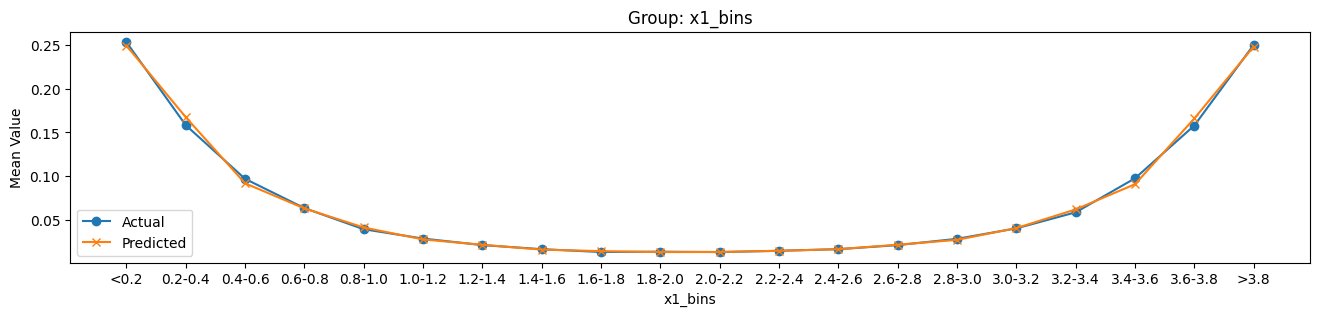

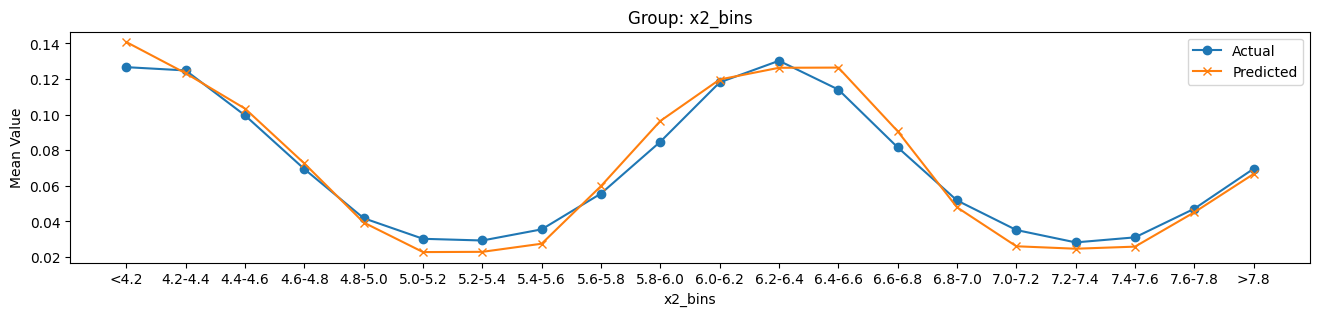

In [37]:
for group in ['x1_bins', 'x2_bins']:
    plt.figure(figsize=(16, 3))
    summary = df.groupby(group, observed=True).agg({'binary_y': 'mean', 'model_predict_BCD': 'mean'})
    plt.plot(summary.index, summary['binary_y'], label='Actual', marker='o')
    plt.plot(summary.index, summary['model_predict_BCD'], label='Predicted', marker='x')
    plt.title(f'Group: {group}')
    plt.xlabel(group)
    plt.ylabel('Mean Value')
    plt.legend()

In [38]:
lpm_scipy = LinearProductModelScipy( xtol=1e-12, ftol=1e-12, gtol=1e-12 )
lpm_scipy.fit( train_df, df['binary_y'], feature_groups=feature_groups, verbose=2, use_jacobian=False)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.4870e+11                                    1.44e+11    
       1              2         8.8703e+10      2.60e+11       4.24e+00       7.40e+10    
       2              4         3.1558e+08      8.84e+10       1.06e+00       4.14e+09    
       3              5         1.9503e+07      2.96e+08       2.12e+00       4.64e+08    
       4              7         1.2734e+06      1.82e+07       1.06e+00       5.67e+07    
       5              8         1.0560e+05      1.17e+06       2.12e+00       3.50e+06    
       6             10         3.1325e+04      7.43e+04       1.06e+00       8.91e+04    
       7             11         2.8639e+04      2.69e+03       2.12e+00       6.47e+02    
       8             13         2.8623e+04      1.60e+01       1.06e+00       3.87e+02    
       9             16         2.8623e+04      6.13e-02       1.33e-01       1.77e+02    

In [39]:
df['model_predict'] = lpm_scipy.predict(train_df)

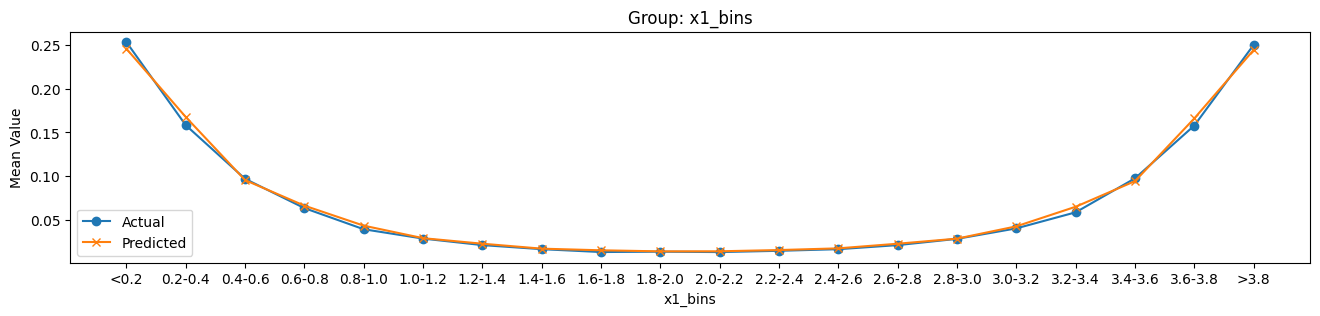

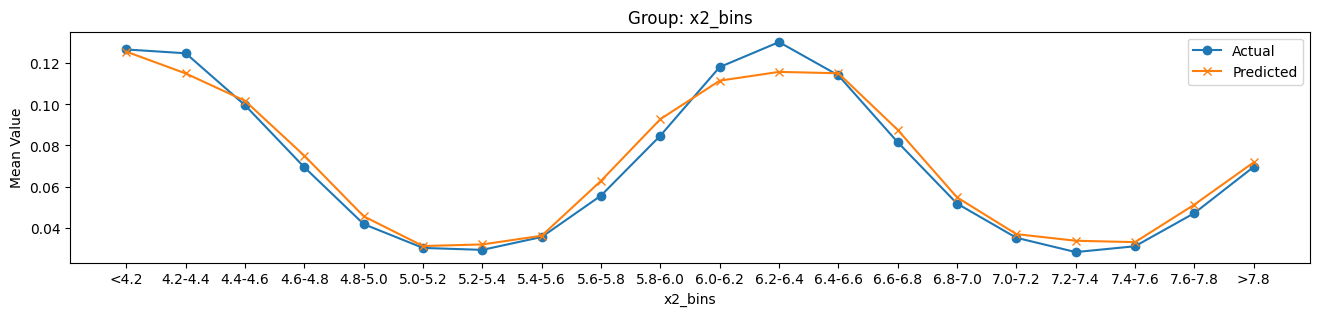

In [40]:
for group in ['x1_bins', 'x2_bins']:
    plt.figure(figsize=(16, 3))
    summary = df.groupby(group, observed=True).agg({'binary_y': 'mean', 'model_predict': 'mean'})
    plt.plot(summary.index, summary['binary_y'], label='Actual', marker='o')
    plt.plot(summary.index, summary['model_predict'], label='Predicted', marker='x')
    plt.title(f'Group: {group}')
    plt.xlabel(group)
    plt.ylabel('Mean Value')
    plt.legend()

In [41]:
# import the mse function
from sklearn.metrics import mean_squared_error
mse_bcd = mean_squared_error(df['binary_y'], df['model_predict_BCD'])
print(f'MSE (Alternating Coordinate Descent + OLS): {mse_bcd:.4f}')
mse_scipy = mean_squared_error(df['binary_y'], df['model_predict'])
print(f'MSE (Scipy Optimization): {mse_scipy:.4f}')

MSE (Alternating Coordinate Descent + OLS): 0.0574
MSE (Scipy Optimization): 0.0572
